In [141]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [142]:
import numpy as np
import pandas as pd

In [143]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [144]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [145]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [146]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [147]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [148]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [149]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [150]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_year_precip = session.query(Measurement.date, Measurement.station, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= '2016-08-24').\
    order_by(Measurement.date.asc()).all()

last_year_precip_df = pd.DataFrame(last_year_precip)
last_year_precip_df.set_index('date', inplace=True, )
last_year_precip_df.head(10)



,station,prcp,tobs
date,,,
2016-08-24,USC00519397,0.08,79.0
2016-08-24,USC00513117,2.15,76.0
2016-08-24,USC00514830,2.28,80.0
2016-08-24,USC00517948,NaN,78.0
2016-08-24,USC00519523,1.22,79.0
2016-08-24,USC00519281,2.15,77.0
2016-08-24,USC00516128,1.45,74.0
2016-08-25,USC00519397,0.08,80.0
2016-08-25,USC00513117,0.08,77.0


In [151]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
one_year_ago_data = session.query(Measurement.date, Measurement.station, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date == one_year_ago).\
    order_by(Measurement.date.desc()).all()

#Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

one_year_ago_df = pd.DataFrame(one_year_ago_data)
one_year_ago_df.set_index('date', inplace=True, )
one_year_ago_df.head(10)




,station,prcp,tobs
date,,,
2016-08-23,USC00519397,0.00,81.0
2016-08-23,USC00513117,0.15,76.0
2016-08-23,USC00514830,0.05,80.0
2016-08-23,USC00517948,NaN,80.0
2016-08-23,USC00519523,0.02,80.0
2016-08-23,USC00519281,1.79,77.0
2016-08-23,USC00516128,0.70,74.0


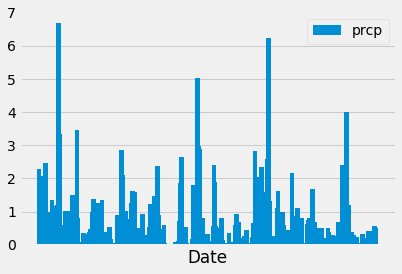

In [152]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.bar(last_year_precip_df.index, last_year_precip_df["prcp"], width=5)
plt.xlabel("Date")
plt.xticks([])
plt.legend(["prcp"])
plt.show()

![precipitation](Images/precipitation.png)

In [153]:
# Use Pandas to calcualte the summary statistics for the precipitation data

all_data = session.query(Measurement.date, Measurement.station, Measurement.prcp, Measurement.tobs).\
    order_by(Measurement.date.desc()).all()

all_data_df = pd.DataFrame(all_data)
all_data_df.describe()


,prcp,tobs
count,18103.000000,19550.000000
mean,0.160644,73.097954
std,0.468746,4.523527
min,0.000000,53.000000
25%,0.000000,70.000000
50%,0.010000,73.000000
75%,0.110000,76.000000
max,11.530000,87.000000


![describe](Images/describe.png)

In [154]:
# Design a query to show how many stations are available in this dataset?
#number_stations = session.query(Station.station).count()
#print(number_stations)

number_stations = session.query(Measurement.station).group_by(Measurement.station).count()
print("There are " + str(number_stations) + " stations.")

There are 9 stations.


In [155]:
# What are the most active stations? (i.e. what stations have the most rows)?
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

# List the stations and the counts in descending order.

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [156]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs),
       func.count(Measurement.tobs)]
most_active_stats = session.query(*sel).group_by(Measurement.station).\
    order_by(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").all()
    
most_active_stats


[('USC00519281', 54.0, 85.0, 71.66378066378067, 2772)]

In [157]:
# Choose the station with the highest number of temperature observations.

session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).first()


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram



('USC00519281', 2772)

In [158]:
#USC00519281

highest_tops = pd.DataFrame(session.query(Measurement.station, Measurement.tobs).\
filter(Measurement.station == "USC00519281").\
filter(Measurement.date > "2016-08-24").all())

highest_tops.head()

,station,tobs
0,USC00519281,80.0
1,USC00519281,80.0
2,USC00519281,75.0
3,USC00519281,73.0
4,USC00519281,78.0


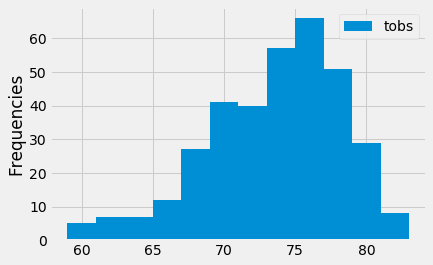

In [163]:
plt.hist(highest_tops["tobs"], bins=12)
plt.ylabel("Frequencies")
plt.legend(["tobs"])
plt.show()

![precipitation](Images/station-histogram.png)